In [154]:
""" # google colab

!pip install rasterio
!pip install rioxarray
!pip install geopandas

"""

In [156]:
""" # google colab
import rasterio
import geopandas as gpd
import rioxarray
from rasterio.plot import show
from pyproj import CRS
from google.colab import drive
import os
import numpy as np
import math
import fiona
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import shapely

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/DREAMS - Zhiang/Projects/3D_rock_detection/data')
print(os.listdir())
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['las_box_filter.py', 'granite_dells_wgs_utm.mtl', 'granite_dells_wgs_utm.obj', 'granite_dells_wgs_utm.jpg', 'granite_dells_wgs_utm.tif', 'annotation_shapefiles', 'pbr_bboxes_wgs_utm.npy', 'box_pbr', 'granite_dells_wgs_utm.las', 'box_pbr_annotation', 'combined.las']


In [47]:
import rasterio
import geopandas as gpd
import rioxarray
from rasterio.plot import show
from pyproj import CRS
import os
import numpy as np
import math
import fiona
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import shapely
import pandas as pd


## Shapefile merger

In [57]:
shapefiles = ["data/rocklas/annotation_shapefiles/free_standing_rock.shp", "data/rocklas/annotation_shapefiles/country_rock_utm.shp"]
gdf1 = gpd.read_file(shapefiles[0])
gdf2 = gpd.read_file(shapefiles[1])


#gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2]))

gdf.to_file('data/rocklas/annotation_shapefiles/merged_rock.shp')


<AxesSubplot:>

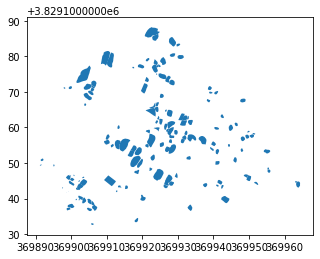

In [54]:
gdf.plot()

<AxesSubplot:>

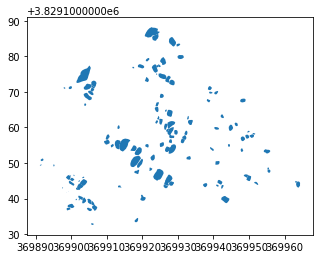

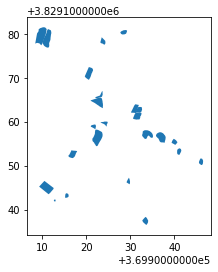

In [53]:
gdf1.plot()
gdf2.plot()

In [58]:
def merge_shapefile(shapefile_list, shapefile_save):
    shapefiles = []
    for shapefile in shapefile_list:
        assert os.path.isfile(shapefile)
        shapefiles.append(shapefile)
    
    shps = [gpd.read_file(shp) for shp in shapefiles]
    gdf = gpd.GeoDataFrame(pd.concat(shps, ignore_index=True), crs=shps[0].crs)
    gdf.to_file(shapefile_save)

In [59]:
ls = ["data/rocklas/annotation_shapefiles/free_standing_rock.shp", "data/rocklas/annotation_shapefiles/country_rock_utm.shp"]

merge_shapefile(ls, 'data/rocklas/annotation_shapefiles/merged_rock.shp')

## Algorithm I

We assign instances to tiles. For each instance:   
1) getting bounding box coordinates of a box  
2) calculating tile indices of the bounding box coordinates  
3) purging the tile indices  
4) intersecting the object shape with the indexed tiles to get instances in the tiles  
Input:  
1) geotiff coordinates (minimum x and y)  
2) tile metric size  
3) polygan-object shapefile   
Output:  
tile shapefiles. Each tile shapefile includes a tile polygon (box) and instance polygons. 


The time complexity of the algorithm is linear with the object number. 

In [60]:
class Tile_Splitter(object):
    def __init__(self, tif_path, shapefile_path, tile_size, save_dir):
        assert os.path.isfile(tif_path)
        assert os.path.isfile(shapefile_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.tile_dir = save_dir
        self.tile_size = tile_size
        self.tif = rioxarray.open_rasterio(tif_path)
        self.x1, self.y1, self.x2, self.y2 = self.tif.rio.bounds()
        self.instances_shp = gpd.read_file(shapefile_path).explode()
        self.tiles = {}

    def split(self):
        for instance in self.instances_shp['geometry']:
            bbox = instance.bounds
            tile_indices = self._calculate_tile_indices(bbox)
            if tile_indices.shape[0] == 1:
                instance_poly = self._extract_instance_polygon(instance)
                self._add_instance(instance_poly, tile_indices[0])
                continue
            for tile_index in self._calculate_tile_indices(bbox):
                tile_poly = self._calculate_tile_polygon(tile_index)
                instance_poly = self._extract_instance_polygon(instance)
                poly = tile_poly.intersection(instance_poly)
                self._add_instance(poly, tile_index)

        self._create_tile_shapefiles()
        self._clip_tiff_tiles()
    
    def _clip_tiff_tiles(self):
        for tile_index in self.tiles:
            i, j = tile_index
            x1 = self.x1 + i*self.tile_size
            x2 = self.x1 + i*self.tile_size + self.tile_size
            y1 = self.y1 + j*self.tile_size 
            y2 = self.y1 + j*self.tile_size + self.tile_size
            clipped_tif = self.tif.rio.clip_box(
                minx=x1,
                miny=y1,
                maxx=x2,
                maxy=y2,
            )
            f = os.path.join(self.tile_dir, "{x}_{y}.tif".format(x=tile_index[0], y=tile_index[1]))
            clipped_tif.rio.to_raster(f)
            print(f)

    def _create_tile_shapefiles(self):
        for tile_index in self.tiles:
            instance_polys = self.tiles[tile_index]
            schema = {'geometry':'Polygon', 'properties':[('name','str')]}
            f = os.path.join(self.tile_dir, "{x}_{y}.shp".format(x=tile_index[0], y=tile_index[1]))
            print(f)
            polyShp = fiona.open(f, mode='w', driver='ESRI Shapefile', schema = schema, crs = self.tif.rio.crs)
            for instance_poly in instance_polys:
                if isinstance(instance_poly, shapely.geometry.multipolygon.MultiPolygon):
                    for ins_poly in instance_poly:
                        x,y = ins_poly.exterior.coords.xy
                        xy = np.asarray((x,y)).transpose()
                        rowDict = {'geometry' : {'type':'Polygon', 'coordinates': [xy]}, 'properties': {'name': 'tile'}}
                        polyShp.write(rowDict)
                    continue
                x,y = instance_poly.exterior.coords.xy
                xy = np.asarray((x,y)).transpose()
                rowDict = {'geometry' : {'type':'Polygon', 'coordinates': [xy]}, 'properties': {'name': 'tile'}}
                polyShp.write(rowDict)

            polyShp.close()
            
    def _add_instance(self, instance_poly, tile_index):
        tile_index = tuple(tile_index)
        result = self.tiles.get(tile_index, False)
        if not result:
            self.tiles[tile_index] = [instance_poly]
        else:
            self.tiles[tile_index].append(instance_poly)

    def _calculate_tile_indices(self, bbox):
        x1, y1, x2, y2 = bbox
        pt0 = (x1, y1)
        pt1 = (x1, y2)
        pt2 = (x2, y1)
        pt3 = (x2, y2)
        pts = (pt0, pt1, pt2, pt3)
        tile_index = []
        for pt in pts:
            i = int((pt[0] - self.x1)/self.tile_size)
            j = int((pt[1] - self.y1)/self.tile_size)
            tile_index.append((i, j))
        
        tile_index = np.asarray(tile_index)
        return np.unique(tile_index, axis=0)

    def _calculate_tile_polygon(self, tile_index):
        i, j = tile_index
        pt0 = (self.x1 + i*self.tile_size, self.y1 + j*self.tile_size)
        pt1 = (self.x1 + i*self.tile_size + self.tile_size, self.y1 + j*self.tile_size)
        pt2 = (self.x1 + i*self.tile_size + self.tile_size, self.y1 + j*self.tile_size + self.tile_size)
        pt3 = (self.x1 + i*self.tile_size, self.y1 + j*self.tile_size + self.tile_size)
        return Polygon((pt0, pt1, pt2, pt3))

    def _extract_instance_polygon(self, instance):
        XYZ = []
        for xyz in instance.boundary.coords:
            XYZ.append(xyz)

        XYZ = np.asarray(XYZ)
        XY = XYZ[:, :2]
        return Polygon(XY)

    def _initiate_tile_shapefiles(self):
        x1, y1, x2, y2 = self.tif.rio.bounds()
        x_N = math.ceil((x2 - x1)/self.tile_size)
        y_N = math.ceil((y2 - y1)/self.tile_size)
        for i in range(x_N):
            for j in range(y_N):
                schema = {'geometry':'Polygon', 'properties':[('name','str')]}
                f = os.path.join(self.tile_dir, "{x}_{y}.shp".format(x=i, y=j))
                polyShp = fiona.open(f, mode='w', driver='ESRI Shapefile', schema = schema, crs = self.tif.rio.crs)
                
                pt0 = (x1 + i*self.tile_size, y1 + j*self.tile_size)
                pt1 = (x1 + i*self.tile_size + self.tile_size, y1 + j*self.tile_size)
                pt2 = (x1 + i*self.tile_size + self.tile_size, y1 + j*self.tile_size + self.tile_size)
                pt3 = (x1 + i*self.tile_size, y1 + j*self.tile_size + self.tile_size)
                tile = [[pt0, pt1, pt2, pt3]]
                rowDict = {'geometry' : {'type':'Polygon', 'coordinates': tile}, 'properties': {'name': 'tile'}}
                polyShp.write(rowDict)

                polyShp.close()
                
                

In [61]:
#ts = Tile_Splitter("data/rocklas/granite_dells_wgs_utm.tif", "data/rocklas/annotation_shapefiles/free_standing_rock.shp", 5, 'data/rocklas/tiles')
ts = Tile_Splitter("data/rocklas/granite_dells_wgs_utm.tif", "data/rocklas/annotation_shapefiles/merged_rock.shp", 5, 'data/rocklas/tiles')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  # This is added back by InteractiveShellApp.init_path()


In [62]:
ts.split()

data/rocklas/tiles/8_16.shp
data/rocklas/tiles/9_16.shp
data/rocklas/tiles/9_15.shp
data/rocklas/tiles/9_14.shp
data/rocklas/tiles/8_14.shp
data/rocklas/tiles/4_13.shp
data/rocklas/tiles/4_14.shp
data/rocklas/tiles/5_13.shp
data/rocklas/tiles/5_14.shp
data/rocklas/tiles/4_12.shp
data/rocklas/tiles/5_12.shp
data/rocklas/tiles/3_13.shp
data/rocklas/tiles/6_11.shp
data/rocklas/tiles/6_9.shp
data/rocklas/tiles/6_10.shp
data/rocklas/tiles/7_9.shp
data/rocklas/tiles/7_10.shp
data/rocklas/tiles/5_10.shp
data/rocklas/tiles/3_8.shp
data/rocklas/tiles/4_8.shp
data/rocklas/tiles/3_6.shp
data/rocklas/tiles/4_6.shp
data/rocklas/tiles/5_6.shp
data/rocklas/tiles/4_7.shp
data/rocklas/tiles/5_7.shp
data/rocklas/tiles/6_7.shp
data/rocklas/tiles/7_7.shp
data/rocklas/tiles/8_7.shp
data/rocklas/tiles/9_7.shp
data/rocklas/tiles/9_8.shp
data/rocklas/tiles/9_10.shp


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


data/rocklas/tiles/9_11.shp
data/rocklas/tiles/10_10.shp
data/rocklas/tiles/10_11.shp
data/rocklas/tiles/9_12.shp
data/rocklas/tiles/9_13.shp
data/rocklas/tiles/7_14.shp
data/rocklas/tiles/8_9.shp
data/rocklas/tiles/8_10.shp
data/rocklas/tiles/7_8.shp
data/rocklas/tiles/8_8.shp
data/rocklas/tiles/9_9.shp
data/rocklas/tiles/11_7.shp
data/rocklas/tiles/11_8.shp
data/rocklas/tiles/12_9.shp
data/rocklas/tiles/13_12.shp
data/rocklas/tiles/13_10.shp
data/rocklas/tiles/14_10.shp
data/rocklas/tiles/13_9.shp
data/rocklas/tiles/14_9.shp
data/rocklas/tiles/15_9.shp
data/rocklas/tiles/3_7.shp
data/rocklas/tiles/5_5.shp
data/rocklas/tiles/2_9.shp
data/rocklas/tiles/3_9.shp
data/rocklas/tiles/8_15.shp
data/rocklas/tiles/8_12.shp
data/rocklas/tiles/15_8.shp
data/rocklas/tiles/13_11.shp
data/rocklas/tiles/14_11.shp
data/rocklas/tiles/12_11.shp
data/rocklas/tiles/11_9.shp
data/rocklas/tiles/11_10.shp
data/rocklas/tiles/12_10.shp
data/rocklas/tiles/10_9.shp
data/rocklas/tiles/13_8.shp
data/rocklas/tiles